In [ ]:
!wget https://goo.gl/8hY5ER -O urbansound8k_metadata.zip

--2025-05-04 00:40:52--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 142.251.2.139, 142.251.2.102, 142.251.2.113, ...
Connecting to goo.gl (goo.gl)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2025-05-04 00:40:52--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-05-04 00:40:53--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urbansound8k_metadata.zip’

urbansound8k_metada 100%[===========

In [ ]:
!file urbansound8k_metadata.zip

urbansound8k_metadata.zip: gzip compressed data, last modified: Tue Jun  3 22:16:05 2014, from Unix, original size modulo 2^32 2802458624


In [ ]:
import tarfile

file_path = "/content/urbansound8k_metadata.zip"  # actually a .tar.gz
extract_path = "/content/UrbanSound8K"

with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paths
DATASET_PATH = "/content/UrbanSound8K/UrbanSound8K"
AUDIO_PATH = os.path.join(DATASET_PATH, "audio")
METADATA_PATH = os.path.join(DATASET_PATH, "metadata", "UrbanSound8K.csv")

# Parameters
SAMPLE_RATE = 22050
DURATION = 4  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
NUM_MFCC = 40

# Load metadata
metadata = pd.read_csv(METADATA_PATH)

# Initialize lists
features = []
labels = []

# Iterate through the dataset
for index, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(AUDIO_PATH, f"fold{row['fold']}", row['slice_file_name'])
    try:
        # Load audio file
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(signal) < SAMPLES_PER_TRACK:
            # Pad short signals
            pad_width = SAMPLES_PER_TRACK - len(signal)
            signal = np.pad(signal, (0, pad_width), mode='constant')
        else:
            signal = signal[:SAMPLES_PER_TRACK]

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=NUM_MFCC)
        mfcc = mfcc.T  # Transpose to (time, mfcc)
        features.append(mfcc)
        labels.append(row['class'])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


100%|██████████| 8732/8732 [03:45<00:00, 38.76it/s]


In [ ]:
X = np.array(features)
y = np.array(labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Expand dimensions for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train.shape[1:]  # (time, mfcc, 1)
num_classes = y_categorical.shape[1]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 171, 38, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 83, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 41, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 41, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,687,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,707,210 (10.33 MB)

 Trainable params: 2,707,210 (10.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.1734 - loss: 7.4444 - val_accuracy: 0.3915 - val_loss: 1.7524
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4263 - loss: 1.5936 - val_accuracy: 0.5180 - val_loss: 1.4255
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5250 - loss: 1.3382 - val_accuracy: 0.5827 - val_loss: 1.2292
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6065 - loss: 1.1370 - val_accuracy: 0.6417 - val_loss: 1.1130
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6600 - loss: 0.9826 - val_accuracy: 0.6966 - val_loss: 0.9598
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7153 - loss: 0.8349 - val_accuracy: 0.7281 - val_loss: 0.8398
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7400 - loss: 0.7391 - val_accuracy: 0.7390 - val_loss: 0.8316
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7745 - loss: 0.6396 - val_accuracy:

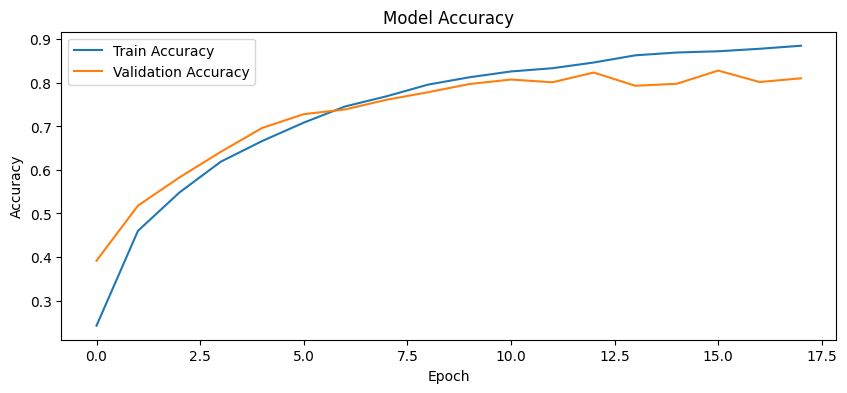

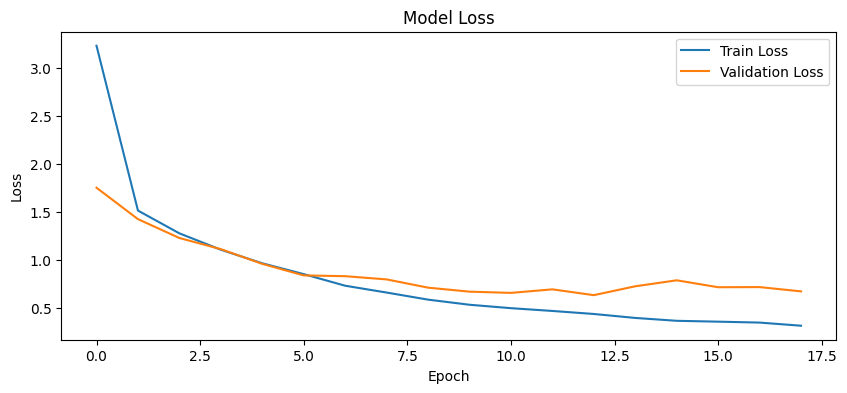

55/55 - 0s - 4ms/step - accuracy: 0.8237 - loss: 0.6342
Test Accuracy: 82.37%


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
